## POS tagging using modified Viterbi

## HMMs and Viterbi algorithm for POS tagging

You have learnt to build your own HMM-based POS tagger and implement the Viterbi algorithm using the Penn Treebank training corpus. The vanilla Viterbi algorithm we had written had resulted in ~87% accuracy. The approx. 13% loss of accuracy was majorly due to the fact that when the algorithm encountered an unknown word (i.e. not present in the training set, such as 'Twitter'), it assigned an incorrect tag arbitrarily. This is because, for unknown words, the emission probabilities for all candidate tags are 0, so the algorithm arbitrarily chooses (the first) tag.
 
In this assignment, you need to modify the Viterbi algorithm to solve the problem of unknown words using at least two techniques. Though there could be multiple ways to solve this problem, you may use the following hints:

- Which tag class do you think most unknown words belong to? Can you identify rules (e.g. based on morphological cues) that can be used to tag unknown words? You may define separate python functions to exploit these rules so that they work in tandem with the original Viterbi algorithm.


- Why does the Viterbi algorithm choose a random tag on encountering an unknown word? Can you modify the Viterbi algorithm so that it considers only one of the transition or emission probabilities for unknown words?
 

You have been given a 'test' file below containing some sample sentences with unknown words. Look at the sentences and try to observe rules which may be useful to tag unknown words. Your final model will be evaluated on a similar test file.

### Data Preparation

In [1]:
#Importing libraries
import nltk

In [2]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [3]:
from sklearn.model_selection import train_test_split
import random

random.seed(9999)
train_set, validation_set = train_test_split(nltk_data, train_size=0.95, random_state=100)
train_tagged_words = [tup for sent in train_set for tup in sent]

print(train_set[:2])
print(len(train_set))

print(validation_set[:2])
print(len(validation_set))

[[('One', 'NUM'), ('bright', 'ADJ'), ('sign', 'NOUN'), ('is', 'VERB'), ('that', 'ADP'), ('a', 'DET'), ('growing', 'VERB'), ('number', 'NOUN'), ('of', 'ADP'), ('women', 'NOUN'), ('have', 'VERB'), ('entered', 'VERB'), ('the', 'DET'), ('once', 'ADV'), ('male-dominated', 'ADJ'), ('field', 'NOUN'), (';', '.'), ('more', 'ADJ'), ('than', 'ADP'), ('a', 'DET'), ('third', 'ADJ'), ('of', 'ADP'), ('the', 'DET'), ('ringers', 'NOUN'), ('today', 'NOUN'), ('are', 'VERB'), ('women', 'NOUN'), ('.', '.')], [('``', '.'), ('These', 'DET'), ('days', 'NOUN'), (',', '.'), ('banking', 'NOUN'), ('customers', 'NOUN'), ('walk', 'VERB'), ('in', 'ADP'), ('the', 'DET'), ('door', 'NOUN'), ('*-1', 'X'), ('expecting', 'VERB'), ('you', 'PRON'), ('to', 'PRT'), ('have', 'VERB'), ('a', 'DET'), ('package', 'NOUN'), ('especially', 'ADV'), ('for', 'ADP'), ('them', 'PRON'), (',', '.'), ("''", '.'), ('Ms.', 'NOUN'), ('Moore', 'NOUN'), ('says', 'VERB'), ('*T*-2', 'X'), ('.', '.')]]
3718
[[('Investors', 'NOUN'), ('took', 'VERB'),

Read the test file and display it in a dataframe

In [4]:
import pandas as pd

pd.set_option('display.max_colwidth', None)
text = pd.read_csv("test_sentences.txt", delimiter="\t", header=None)
text

,0
0,Android is a mobile operating system developed by Google.
1,Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.
2,Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.
3,Twitter is an online news and social networking service on which users post and interact with messages known as tweets.
4,"Before entering politics, Donald Trump was a domineering businessman and a television personality."
5,"The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years."
6,This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.
7,Show me the cheapest round trips from Dallas to Atlanta
8,I would like to see flights from Denver to Philadelphia.
9,Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.


In [5]:
from nltk.tokenize import word_tokenize

with open("test_sentences.txt", "r") as file:
    content = file.readlines()

file_content = [line for line in content if line != '\n']

test_sentence_list = [sentence for sentence in file_content]
test_list = [word for sentence in file_content for word in word_tokenize(sentence)]

In [6]:
# number of tags in the training set
T = set([pair[1] for pair in train_tagged_words])

### Build the vanilla Viterbi based POS tagger

In [7]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

In [8]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability
def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [9]:
# Viterbi Heuristic
T = list(set([pair[1] for pair in train_tagged_words]))

def vanilla_viterbi(words, train_bag = train_tagged_words):
    state = []
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            result = word_given_tag(word, tag)
            emission_p = result[0]/result[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [10]:
import numpy as np

# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

print(T)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)):
        #print(t2 + " " + t1)
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

['ADP', 'NUM', 'DET', 'ADJ', 'CONJ', 'PRT', 'VERB', 'X', 'PRON', 'ADV', 'NOUN', '.']


In [11]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))

Create a function that executes the different viterbi implementations and returns the accuracy, list of incorrect cases and the 

In [12]:
import time

def run_viterbi(test_sentences, viterbi):
    # Get test words from test_sentences
    test_run_tuples = [tup for sentences in test_sentences for tup in sentences]
    test_words = [tup[0] for tup in test_run_tuples]
    
    start = time.time()
    # Tagging the test sentences
    tagged_sequence = viterbi(test_words)
    
    difference = round(time.time()-start, 2)
    print(f"Time taken: {difference} s")

    # Check Accuracy
    correctly_tagged_cases = [i for i, j in zip(tagged_sequence, test_run_tuples) if i == j]
    accuracy = round(len(correctly_tagged_cases)*100/len(tagged_sequence), 2)
    print(f"Accuracy: {accuracy}%")
    
    # Print Incorrectly tagged cases
    incorrectly_tagged_cases = [[test_run_tuples[i-1],j] for i, j in enumerate(zip(tagged_sequence, test_run_tuples)) if j[0]!=j[1]]
    print(f"Number of incorrectly tagged words: {len(incorrectly_tagged_cases)}")

    return (accuracy, incorrectly_tagged_cases, difference)

In [13]:
vanilla_viterbi_validation_results = run_viterbi(validation_set, vanilla_viterbi)

Time taken: 277.66 s
Accuracy: 90.42%
Number of incorrectly tagged words: 453


### Running vanilla Viterbi on the test data

In [14]:
print(vanilla_viterbi(test_list))

[('Android', 'ADP'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'ADP'), ('.', '.'), ('Android', 'ADP'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'ADP'), ('worldwide', 'ADP'), ('on', 'ADP'), ('smartphones', 'ADP'), ('since', 'ADP'), ('2011', 'ADP'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'ADP'), ('.', '.'), ('Google', 'ADP'), ('and', 'CONJ'), ('Twitter', 'ADP'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'ADP'), ('that', 'DET'), ('gave', 'VERB'), ('Google', 'ADP'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'ADP'), ("'s", 'PRT'), ('firehose', 'ADP'), ('.', '.'), ('Twitter', 'ADP'), ('is', 'VERB'), ('an', 'DET'), ('online', 'ADP'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), ('users', 'NOU

### Solve the problem of unknown words

Display the mismatched words

In [15]:
print(vanilla_viterbi_validation_results[1])

[[('to', 'PRT'), (('book', 'NOUN'), ('book', 'VERB'))], [('leaving', 'VERB'), (('stocks', 'NOUN'), ('stocks', 'ADV'))], [('stocks', 'ADV'), (('up', 'PRT'), ('up', 'ADP'))], [('carried', 'VERB'), (('over', 'ADP'), ('over', 'PRT'))], [('apparently', 'ADV'), (('ignored', 'ADP'), ('ignored', 'VERB'))], [('Chilean', 'ADJ'), (('mine', 'NOUN'), ('mine', 'ADJ'))], [('the', 'DET'), (('Palestinian', 'ADJ'), ('Palestinian', 'NOUN'))], [('committee', 'NOUN'), (('first', 'ADJ'), ('first', 'ADV'))], [('.', '.'), (('Preston', 'ADP'), ('Preston', 'NOUN'))], [('Foster', 'NOUN'), (('Birmingham', 'ADP'), ('Birmingham', 'NOUN'))], [(',', '.'), (('Ala', 'ADP'), ('Ala', 'NOUN'))], [('has', 'VERB'), (('clamped', 'ADP'), ('clamped', 'VERB'))], [('their', 'PRON'), (('ankle', 'ADP'), ('ankle', 'NOUN'))], [('the', 'DET'), (('third-largest', 'ADP'), ('third-largest', 'ADJ'))], [('the', 'DET'), (('fifth-largest', 'ADP'), ('fifth-largest', 'ADJ'))], [('Charles', 'NOUN'), (('Z.', 'ADP'), ('Z.', 'NOUN'))], [('Z.', 'N

#### Modification technique 1

Creating a function that implements a smoothening transform that prevent the state probability from becoming zero when the emission probability is zero

In [16]:
T = list(set([pair[1] for pair in train_tagged_words]))

def modified_viterbi(words, train_bag = train_tagged_words):
    state = []
    
    epsilon = 0.000001
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            result = word_given_tag(word, tag)
            emission_p = result[0]/result[1]
            state_probability = (emission_p + epsilon) * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        
        if pmax!=0:
            # getting state for which probability is maximum
            state_max = T[p.index(pmax)]
            
        state.append(state_max)
    return list(zip(words, state))

#### Evaluating tagging accuracy

In [17]:
modified_viterbi_validation_results = run_viterbi(validation_set, modified_viterbi)

Time taken: 287.11 s
Accuracy: 93.36%
Number of incorrectly tagged words: 314


### Running modified Viterbi1 on the test data

In [18]:
print(modified_viterbi(test_list))

[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'DET'), ('.', '.'), ('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'DET'), ('since', 'ADP'), ('2011', 'DET'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'DET'), ('.', '.'), ('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'DET'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'X'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'VERB'), ("'s", 'PRT'), ('firehose', 'VERB'), ('.', '.'), ('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), ('user

#### Modification technique 2

Unigram tagger with backoff regular expression tagger

In [19]:
def get_custom_regexp_tagger():
    patterns = [
        (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'), # numbers
        (r'.*', 'NOUN'),                  # nouns
        (r'.*\'s$', 'NOUN'),              # possessive nouns
        (r'.*s$', 'NOUN'),                # plural nouns
        (r'.*(ing|ed|es)$', 'VERB'),      # verbs
        (r'\*T?\*?-[0-9]+$', 'X')         # miscellaneous words etc.
    ]
    return nltk.RegexpTagger(patterns)

In [20]:
unigram_regex_backoff_tagger = nltk.UnigramTagger(train_set, backoff = get_custom_regexp_tagger())
unigram_regex_backoff_tagger_accuracy = unigram_regex_backoff_tagger.evaluate(validation_set)
print(f"Accuracy: {round(unigram_regex_backoff_tagger_accuracy*100, 2)}%")

Accuracy: 93.99%


In [21]:
T = list(set([pair[1] for pair in train_tagged_words]))

def unigram_regex_viterbi(words, lexicon_tagger=unigram_regex_backoff_tagger, train_bag = train_tagged_words):
    state = []
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            result = word_given_tag(word, tag)
            emission_p = result[0]/result[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        
        if pmax!=0:
            # getting state for which probability is maximum
            state_max = T[p.index(pmax)]
        else:
            state_max = lexicon_tagger.tag([word])[0][1]
            
        state.append(state_max)
    return list(zip(words, state))

In [22]:
unigram_regex_viterbi_validation_results = run_viterbi(validation_set, unigram_regex_viterbi)

Time taken: 290.77 s
Accuracy: 94.14%
Number of incorrectly tagged words: 277


### Running unigram tagger with backoff regular expression Viterbi on the test data

In [23]:
print(unigram_regex_viterbi(test_list))

[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.'), ('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'NOUN'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.'), ('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NUM'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'NOUN'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'NOUN'), ("'s", 'PRT'), ('firehose', 'NOUN'), ('.', '.'), ('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), (

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [24]:
accuracy = pd.DataFrame(data = {
    'Method': [
        'Vanilla Viterbi',
        'Viterbi with smoothening',
        'Viterbi with Lexicon Tagger', 
    ],
    'Accuracy': [
         vanilla_viterbi_validation_results[0], 
         modified_viterbi_validation_results[0],
         unigram_regex_viterbi_validation_results[0]
    ]
})

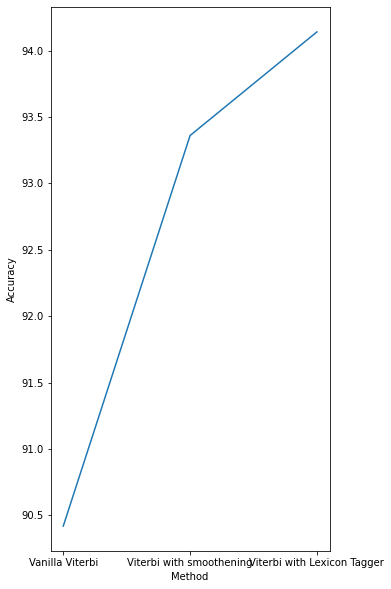

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5, 10))

sns.lineplot(x='Method', y='Accuracy', data=accuracy)
plt.show()

In [26]:
accuracy

,Method,Accuracy
0,Vanilla Viterbi,90.42
1,Viterbi with smoothening,93.36
2,Viterbi with Lexicon Tagger,94.14


### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [27]:
def compare_algorithms(sentence):
    words = word_tokenize(sentence)
    
    print("Vanilla Viterbi")
    print(vanilla_viterbi(words))
    print()
    print("Viterbi with smoothening")
    print(modified_viterbi(words))
    print()
    print("Viterbi with Lexicon Tagger")
    print(unigram_regex_viterbi(words))

In [28]:
compare_algorithms(test_sentence_list[0])

Vanilla Viterbi
[('Android', 'ADP'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'ADP'), ('.', '.')]

Viterbi with smoothening
[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'DET'), ('.', '.')]

Viterbi with Lexicon Tagger
[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.')]


**Android** has been correctly tagged as a noun using both Viterbi with smoothening and Viterbi with Lexicon Tagger 

**Google** has been correctly tagged as a noun using Viterbi with Lexicon Tagger 

In [29]:
compare_algorithms(test_sentence_list[1])

Vanilla Viterbi
[('Android', 'ADP'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'ADP'), ('worldwide', 'ADP'), ('on', 'ADP'), ('smartphones', 'ADP'), ('since', 'ADP'), ('2011', 'ADP'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'ADP'), ('.', '.')]

Viterbi with smoothening
[('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'DET'), ('since', 'ADP'), ('2011', 'DET'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'DET'), ('.', '.')]

Viterbi with Lexicon Tagger
[('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'NOUN'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.')

**Android**, **OS**, **worldwide** have been correctly tagged as a noun using both Viterbi with smoothening and Viterbi with Lexicon Tagger 

**smartphones**, **2011**, **2013** have been correctly tagged as a noun or number using Viterbi with Lexicon Tagger 